# Concept Drift Detection Methods Benchmark

In [1]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
import sys
import os

# matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# River imports
from river import compose, linear_model, preprocessing, metrics
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape
from d3 import d3

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)
warnings.filterwarnings('ignore')



In [2]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies


In [3]:
def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=100):
    """Calculate Mean Time To Detection and TP/FP/FN metrics with one-to-one matching."""
    if true_drifts is None:
        true_drifts = []

    sorted_drifts = sorted(int(d) for d in true_drifts)
    sorted_detections = sorted(int(d) for d in detections)

    if len(sorted_drifts) == 0:
        return {
            'ground_truth_available': False,
            'mttd': np.nan,
            'tp': np.nan,
            'fp': np.nan,
            'fn': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'detection_delays': []
        }

    tp = 0
    fn = 0
    used_detection_idx = set()
    detection_delays = []

    det_pointer = 0
    for drift in sorted_drifts:
        while det_pointer < len(sorted_detections) and sorted_detections[det_pointer] < drift:
            det_pointer += 1

        best_idx = None
        best_delay = None
        search_idx = det_pointer
        while search_idx < len(sorted_detections):
            det = sorted_detections[search_idx]
            delay = det - drift
            if delay > acceptable_delta:
                break
            if det >= drift and search_idx not in used_detection_idx:
                if best_delay is None or delay < best_delay:
                    best_delay = delay
                    best_idx = search_idx
            search_idx += 1

        if best_idx is not None:
            tp += 1
            detection_delays.append(float(best_delay))
            used_detection_idx.add(best_idx)
        else:
            fn += 1

    fp = sum(1 for idx in range(len(sorted_detections)) if idx not in used_detection_idx)
    mttd = float(np.mean(detection_delays)) if detection_delays else float('inf')

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return {
        'ground_truth_available': True,
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'detection_delays': detection_delays
    }


In [4]:
def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


In [5]:
def evaluate_window_based_method(
    X, y, true_drifts, method_name, chunk_size=150, overlap=100,
    cooldown=None, d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05
):
    
    if cooldown is None:
        cooldown = chunk_size // 2

    start_mem = monitor_resources()
    t0_all = time.perf_counter()

    method_detections = []
    runtime_per_batch_ms = []
    drift_estimates = []
    true_drift_scores = []
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []

    shift = chunk_size - overlap
    batches = []
    for i in range(int(X.shape[0] / shift) - int(chunk_size / shift) + 1):
        batch_indices = np.arange(i * shift, min(chunk_size + i * shift, X.shape[0]))
        batches.append(batch_indices)

    batch_count = len(batches)
    last_det = -10**9

    # Precompute ShapeDD p-values once per stream
    shape_total_time_ms = 0.0
    if method_name == 'ShapeDD':
        t_shape0 = time.perf_counter()
        shp_full = shape(X, 50, chunk_size, 2500)
        shp_pvals = shp_full[:, 2]
        t_shape1 = time.perf_counter()
        shape_total_time_ms = (t_shape1 - t_shape0) * 1000.0

    for b in batches:
        xb = X[b]
        yb = y[b]
        t1 = time.perf_counter()

        # Drift score replicates the continuous analysis when drift states are supplied
        if len(yb) > 1:
            drift_score = (yb[None, :] != yb[:, None]).sum() / (len(yb) * (len(yb) - 1))
        else:
            drift_score = 0.0
        true_drift_scores.append(float(drift_score))

        try:
            if method_name == 'D3':
                d3_estimates = {
                    'linear': d3(xb),
                    'extra_trees': d3(xb, ExtraTreesClassifier(max_depth=5)),
                    'random_forest': d3(xb, RandomForestClassifier(max_depth=5)),
                    'knn': d3(xb, KNeighborsClassifier())
                }
                est = float(d3_estimates['linear'])
                trigger = est > d3_threshold
                det_pos = b[-1]

            elif method_name == 'DAWIDD':
                _, est = dawidd(xb, 'rbf')
                est = float(est)
                trigger = est < dawidd_alpha
                det_pos = b[-1]

            elif method_name == 'ShapeDD':
                batch_pvals = shp_pvals[b]
                est = float(batch_pvals.min())
                trigger = est < shape_alpha
                det_pos = b[int(np.argmin(batch_pvals))]

            else:
                raise ValueError(f'Unknown window method: {method_name}')

        except Exception as exc:
            print(f'Error in {method_name}: {exc}')
            est, trigger, det_pos = 0.0, False, b[-1]

        drift_estimates.append(est)

        if trigger and (det_pos - last_det >= cooldown):
            method_detections.append(int(det_pos))
            last_det = det_pos

        batch_ms = (time.perf_counter() - t1) * 1000.0
        if method_name == 'ShapeDD':
            batch_ms += shape_total_time_ms / max(1, batch_count)
        runtime_per_batch_ms.append(batch_ms)

    total_time_s = time.perf_counter() - t0_all
    end_mem = monitor_resources()
    memory_mb = max(0.0, end_mem - start_mem)

    estimate_correlation = 0.0
    if len(drift_estimates) > 1 and len(true_drift_scores) > 1:
        try:
            est_arr = np.asarray(drift_estimates, dtype=float)
            tds_arr = np.asarray(true_drift_scores, dtype=float)
            if len(est_arr) == len(tds_arr) and np.std(est_arr) > 0 and np.std(tds_arr) > 0:
                estimate_correlation = np.corrcoef(est_arr, tds_arr)[0, 1]
                if method_name in ['DAWIDD', 'ShapeDD']:
                    estimate_correlation = -estimate_correlation
        except Exception as exc:
            print(f'Warning: Could not calculate correlation for {method_name}: {exc}')
            estimate_correlation = 0.0

    mttd_metrics = calculate_mttd_metrics(method_detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': method_detections,
        'drift_estimates': drift_estimates,
        'true_drift_scores': true_drift_scores,
        'true_drifts_reference': true_drift_reference,
        'estimate_correlation': float(estimate_correlation),
        'runtime_per_batch_ms': float(np.mean(runtime_per_batch_ms)) if runtime_per_batch_ms else 0.0,
        'runtime_per_instance_ms': (total_time_s * 1000.0) / max(1, len(X)),
        'total_runtime_s': total_time_s,
        'memory_mb': memory_mb,
        **mttd_metrics
    }


In [6]:
def evaluate_streaming_method(
    X, y, true_drifts=None, method_name=None, feature_names=None,
    stream_dicts=None, initial_train_period=200, warm_start_window=200,
    detection_cooldown=5
):
    """Evaluate River streaming drift detectors with incremental learning."""
    if method_name is None:
        raise ValueError('A drift detector name must be provided.')

    start_memory = monitor_resources()
    start_time = time.time()

    def make_detector(name):
        if name == 'ADWIN':
            return ADWIN(delta=0.002)
        if name == 'DDM':
            return DDM()
        if name == 'EDDM':
            return EDDM(alpha=0.95, beta=0.9)
        if name == 'HDDM_A':
            return HDDM_A()
        if name == 'HDDM_W':
            return HDDM_W()
        if name == 'FHDDM':
            return FHDDM(short_window_size=20)
        raise ValueError(f"Unknown streaming method: {name}")

    def make_model():
        return compose.Pipeline(
            preprocessing.OneHotEncoder(),
            linear_model.LogisticRegression()
        )

    drift_detector = make_detector(method_name)
    model = make_model()

    y_array = np.asarray(y)
    y_list = y_array.tolist()

    if stream_dicts is not None:
        stream_sequence = list(stream_dicts)
    else:
        X_array = np.asarray(X)
        if feature_names is None:
            feature_names = [f'f_{j}' for j in range(X_array.shape[1])]
        stream_sequence = []
        for row in X_array:
            feature_map = {feature_names[idx]: float(row[idx]) for idx in range(len(feature_names))}
            stream_sequence.append(feature_map)

    if len(stream_sequence) != len(y_list):
        raise ValueError('Feature stream and label stream must have the same length.')

    detections = []
    runtime_per_instance = []
    predictions = []
    accuracies = []
    recent_buffer = deque(maxlen=warm_start_window)
    accuracy_metric = metrics.Accuracy()
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []
    last_detection_idx = -10**9

    for i, (x_raw, y_true_val) in enumerate(zip(stream_sequence, y_list)):
        instance_start = time.time()
        x_dict = dict(x_raw)
        if isinstance(y_true_val, np.generic):
            y_true = y_true_val.item()
        else:
            y_true = y_true_val

        y_pred = model.predict_one(x_dict)
        predictions.append(int(y_pred) if isinstance(y_pred, (np.integer, np.bool_, bool)) else (y_pred if y_pred is not None else 0))

        in_warmup = (i < initial_train_period) or (y_pred is None)
        if not in_warmup:
            is_correct = int(y_pred == y_true)
            accuracies.append(is_correct)
            accuracy_metric.update(y_true, y_pred)
            error_signal = 1 - is_correct
            if method_name == 'ADWIN':
                drift_detector.update(float(error_signal))
            else:
                drift_detector.update(bool(error_signal))

            if drift_detector.drift_detected and (i - last_detection_idx) >= detection_cooldown:
                detections.append(i)
                last_detection_idx = i
                tail_samples = list(recent_buffer)[-min(50, len(recent_buffer)):]
                drift_detector = make_detector(method_name)
                model = make_model()
                recent_buffer.clear()
                recent_buffer.extend(tail_samples)
                for x_hist, y_hist in tail_samples:
                    model.learn_one(dict(x_hist), y_hist)
        else:
            accuracies.append(0)

        model.learn_one(x_dict, y_true)
        recent_buffer.append((dict(x_dict), y_true))

        instance_time = (time.time() - instance_start) * 1000.0
        runtime_per_instance.append(instance_time)

    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0.0, end_memory - start_memory)

    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)

    post_burnin_start = min(initial_train_period, len(accuracies))
    post_burnin_accuracies = accuracies[post_burnin_start:]
    moving_accuracy = float(np.mean(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    accuracy_std = float(np.std(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    prequential_accuracy = accuracy_metric.get() if getattr(accuracy_metric, 'n_samples', 0) > 0 else 0.0

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': float(np.mean(runtime_per_instance)) if runtime_per_instance else 0.0,
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        'prequential_accuracy': prequential_accuracy,
        'moving_accuracy': moving_accuracy,
        'accuracy_std': accuracy_std,
        'predictions': predictions,
        'accuracies': accuracies,
        'true_drifts_reference': true_drift_reference,
        **mttd_metrics
    }


In [7]:
unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 1, 'number': 3, 'alt': True, 'length': 1000, 'dims': 3}
    }
]

# Methods to evaluate
window_methods = ['D3', 'DAWIDD', 'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']


In [8]:
def make_labels(X, e, angle_step_deg=25.0, bias=0.0, noise_rate=0.01, seed=42):
    rng = np.random.default_rng(seed)
    X = np.asarray(X)
    e = np.asarray(e)
    n, d = X.shape
    if d < 2:
        score = X.sum(axis=1) - bias
        y = (score > 0).astype(int)
    else:
        phi = np.deg2rad(angle_step_deg) * e
        w0 = np.cos(phi)
        w1 = np.sin(phi)
        score = w0 * X[:, 0] + w1 * X[:, 1] - bias
        y = (score > 0).astype(int)

    if noise_rate and noise_rate > 0:
        flips = rng.random(n) < noise_rate
        y[flips] ^= 1
    return y


In [9]:
# Process each scenario in the unified_scenarios list
for scenario in unified_scenarios:
    scenario_name = scenario['name']
    params = scenario['params']
    
    label_config = scenario.get('label_config', {
        'angle_step_deg': 25.0,
        'bias': 0.0,
        'noise_rate': 0.01,
        'seed': 42,
    })
    
    break


In [10]:
# Generate data
X, e = gen_random(**params)
y = make_labels(X, e, **label_config)
# Calculate true drift positions from the drift indicator
true_drifts = np.where(np.diff(e) != 0)[0] + 1
stream_feature_names = [f'x_{idx}' for idx in range(X.shape[1])]


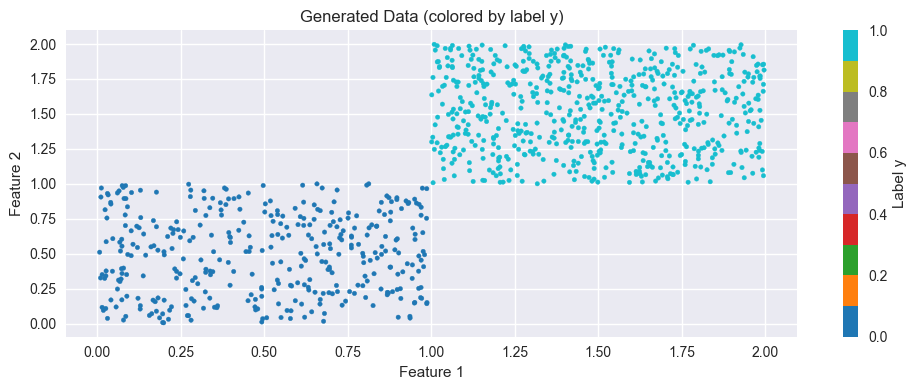

In [11]:
plt.figure(figsize=(10, 4))
if X.shape[1] == 1:
    plt.scatter(range(len(X)), X[:, 0], c=e, cmap='tab10', s=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')
elif X.shape[1] == 2:
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
else:
    # For higher dimensions, plot first two features colored by y
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
plt.title('Generated Data (colored by label y)')
plt.colorbar(label='Label y')
plt.tight_layout()
plt.show()


In [12]:
def run_unified_experiment(scenario_config):
    print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  True drifts at: {list(true_drifts)}")
    
    results = []
    
    # Evaluate window-based methods
    for method_name in window_methods:
        try:
            print(f"  Running {method_name}")
            result = evaluate_window_based_method(X, e, true_drifts, method_name)
            result['scenario'] = scenario_name
            results.append(result)
        except Exception as exc:
            print(f"    Error in {method_name}: {exc}")
            continue
    
    # Evaluate streaming methods
    for method_name in streaming_methods:
        try:
            print(f"  Running {method_name}")
            result = evaluate_streaming_method(
                X,
                y,
                true_drifts,
                method_name,
                feature_names=stream_feature_names
            )
            result['scenario'] = scenario_name
            results.append(result)
        except Exception as exc:
            print(f"    Error in {method_name}: {exc}")
            continue
    
    # Force garbage collection
    gc.collect()
    
    return results


In [13]:
all_unified_results = []

for scenario in unified_scenarios:
    scenario_results = run_unified_experiment(scenario)
    all_unified_results.extend(scenario_results)
    
    print(f"Completed scenario: {scenario['name']}")

# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


  Data: 1000 samples, 3 features
  True drifts at: [np.int64(202), np.int64(370), np.int64(535)]
  Running D3
  Running DAWIDD
  Running ShapeDD
  Running ADWIN
  Running DDM
  Running EDDM
  Running HDDM_A
  Running HDDM_W
  Running FHDDM
Completed scenario: Common_Drift


In [14]:
# Extract true drifts from the first scenario (since we know the data generation parameters)
scenario_params = unified_scenarios[0]['params']  # Get the parameters used

print(f"Extracted {len(true_drifts)} true drift points: {list(true_drifts)}")

# Calculate F1-score
unified_df['f1_score'] = 2 * unified_df['precision'] * unified_df['recall'] / (unified_df['precision'] + unified_df['recall'])
unified_df['f1_score'] = unified_df['f1_score'].fillna(0)

# Academic summary table
summary_table = unified_df.groupby(['paradigm', 'method']).agg({
    'precision': 'mean',
    'recall': 'mean', 
    'f1_score': 'mean',
    'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
    'runtime_per_instance_ms': 'mean',
    'tp': 'sum',
    'fp': 'sum',
    'fn': 'sum'
}).round(4)

print("\nPerformance Metrics by Method")
print(f"{'Method':<12} {'Paradigm':<10} {'Precision':<10} {'Recall':<8} {'F1':<8} {'MTTD':<8} {'Runtime(ms)':<12}")

for (paradigm, method), row in summary_table.iterrows():
    mttd_str = f"{row['mttd']:.1f}" if row['mttd'] != float('inf') else "∞"
    print(f"{method:<12} {paradigm:<10} {row['precision']:<10.3f} {row['recall']:<8.3f} "
            f"{row['f1_score']:<8.3f} {mttd_str:<8} {row['runtime_per_instance_ms']:<12.4f}")


Extracted 3 true drift points: [np.int64(202), np.int64(370), np.int64(535)]

Performance Metrics by Method
Method       Paradigm   Precision  Recall   F1       MTTD     Runtime(ms) 
ADWIN        streaming  0.000      0.000    0.000    ∞        3.9272      
DDM          streaming  0.500      0.667    0.571    55.5     1.3922      
EDDM         streaming  0.000      0.000    0.000    ∞        3.8187      
FHDDM        streaming  0.000      0.000    0.000    ∞        4.7378      
HDDM_A       streaming  0.000      0.000    0.000    ∞        4.0232      
HDDM_W       streaming  0.000      0.000    0.000    ∞        4.6228      
D3           window     0.000      0.000    0.000    ∞        6.4617      
DAWIDD       window     0.750      1.000    0.857    46.7     6.8789      
ShapeDD      window     0.667      0.667    0.667    0.0      0.1538      


In [16]:
# Define colors and markers
colors = {'window': '#2E86AB', 'streaming': '#A23B72'}  # Professional blue/burgundy
markers = {'window': 'o', 'streaming': 's'}


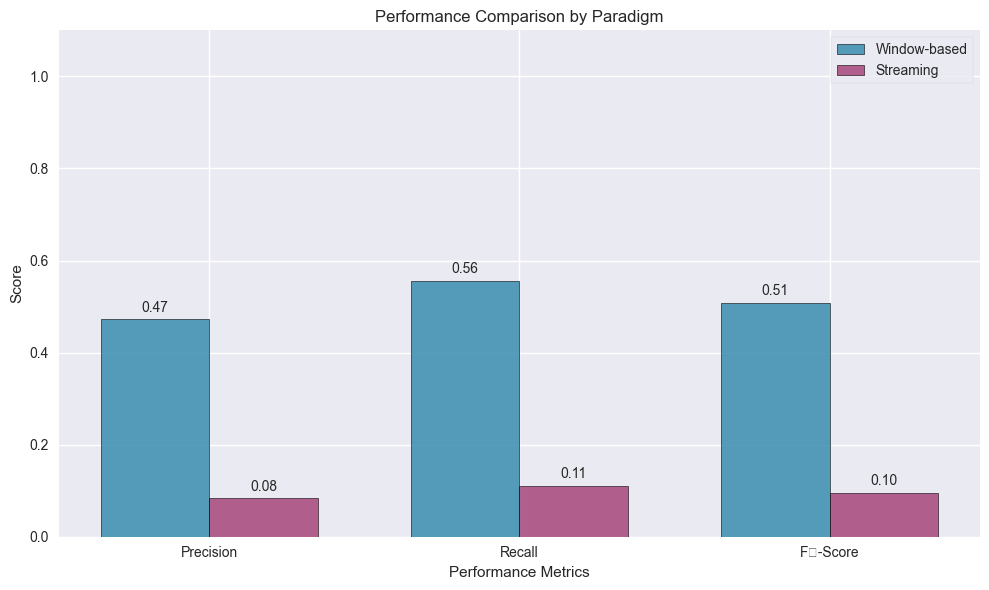

In [17]:
# Plot 1: Performance Comparison by Paradigm
plt.figure(figsize=(10, 6))
metric_keys = ['precision', 'recall', 'f1_score']
metric_labels = ['Precision', 'Recall', 'F₁-Score']

x = np.arange(len(metric_labels))
width = 0.35

window_means = [unified_df[unified_df['paradigm'] == 'window'][m].mean() for m in metric_keys]
streaming_means = [unified_df[unified_df['paradigm'] == 'streaming'][m].mean() for m in metric_keys]

bars1 = plt.bar(x - width/2, window_means, width, label='Window-based', 
                color=colors['window'], alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x + width/2, streaming_means, width, label='Streaming', 
                color=colors['streaming'], alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (w_val, s_val) in enumerate(zip(window_means, streaming_means)):
    plt.text(i - width/2, w_val + 0.01, f'{w_val:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, s_val + 0.01, f'{s_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison by Paradigm')
plt.xticks(x, metric_labels)
plt.legend(frameon=True, fancybox=False, shadow=False)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


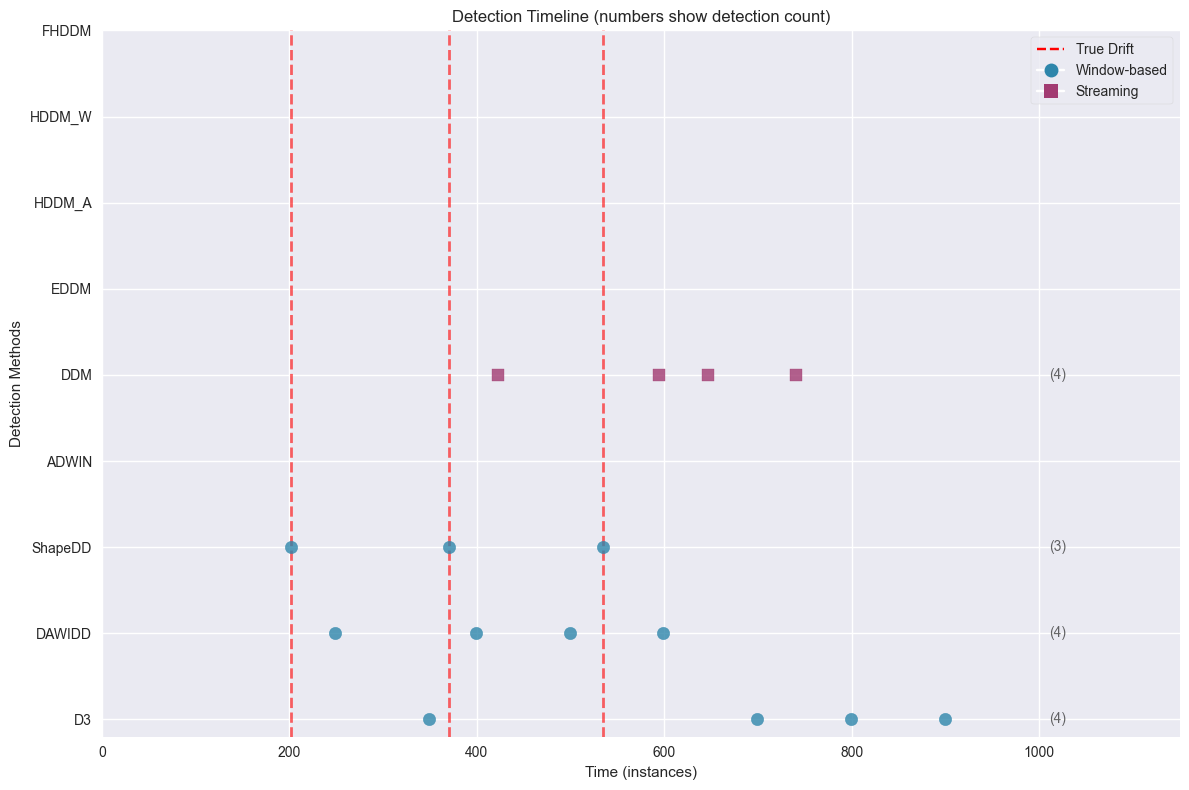

In [18]:
# Plot 2: Detection Timeline Analysis
plt.figure(figsize=(12, 8))

# Plot true drifts as vertical lines
for drift in true_drifts:
    plt.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=1)

# Create method mapping for y-positions with clear labels
method_names = []
y_positions = []
y_pos = 0

# Process window methods first, then streaming
for paradigm in ['window', 'streaming']:
    paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
    for _, row in paradigm_data.iterrows():
        method_name = f"{row['method']}"
        method_names.append(method_name)
        y_positions.append(y_pos)
        
        detections = row['detections']
        if len(detections) > 0:
            plt.scatter(detections, [y_pos] * len(detections), 
                        c=colors[paradigm], marker=markers[paradigm], 
                        s=80, alpha=0.8, zorder=2, 
                        label=f"{paradigm.title()}" if method_name == paradigm_data.iloc[0]['method'] else "")
        
        # Add detection count annotation
        if len(detections) > 0:
            plt.text(scenario_params['length'] * 1.01, y_pos, f"({len(detections)})", 
                    va='center', fontsize=10, alpha=0.7)
        
        y_pos += 1

plt.xlabel('Time (instances)')
plt.ylabel('Detection Methods')
plt.title('Detection Timeline (numbers show detection count)')
plt.xlim(0, scenario_params['length'] * 1.15)
plt.yticks(range(len(method_names)), method_names, fontsize=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linestyle='--', label='True Drift'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['window'], 
                        markersize=10, label='Window-based'),
                    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['streaming'], 
                        markersize=10, label='Streaming')]
plt.legend(handles=legend_elements, frameon=True, loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# Plot 3: Precision-Recall Trade-off Analysis
plt.figure(figsize=(10, 8))

for paradigm in ['window', 'streaming']:
    data = unified_df[unified_df['paradigm'] == paradigm]
    scatter = plt.scatter(data['recall'], data['precision'], 
                        c=colors[paradigm], marker=markers[paradigm], s=120, 
                        alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add method labels
    for _, row in data.iterrows():
        plt.annotate(row['method'], (row['recall'], row['precision']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1, label='Perfect Trade-off')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Trade-off Analysis', fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=11)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


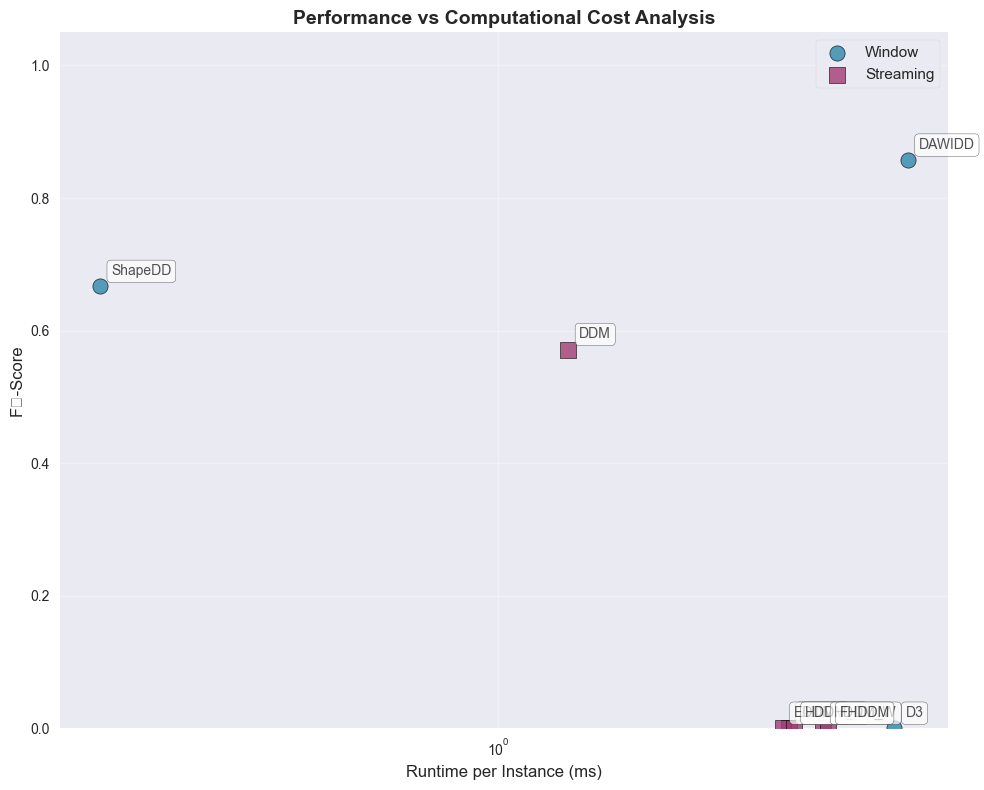

In [19]:
# Plot 4: Performance vs Computational Cost Analysis
plt.figure(figsize=(10, 8))

for paradigm in ['window', 'streaming']:
    data = unified_df[unified_df['paradigm'] == paradigm]
    scatter = plt.scatter(data['runtime_per_instance_ms'], data['f1_score'], 
                        c=colors[paradigm], marker=markers[paradigm], s=120, 
                        alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add method labels
    for _, row in data.iterrows():
        plt.annotate(row['method'], (row['runtime_per_instance_ms'], row['f1_score']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel('Runtime per Instance (ms)', fontsize=12)
plt.ylabel('F₁-Score', fontsize=12)
plt.title('Performance vs Computational Cost Analysis', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend(frameon=True, fontsize=11)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Plot 5: Detection Count vs True Drifts Analysis
plt.figure(figsize=(12, 6))

methods = unified_df['method'].tolist()
detection_counts = [len(row['detections']) for _, row in unified_df.iterrows()]
true_drift_count = len(true_drifts)

bars = plt.bar(range(len(methods)), detection_counts, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.axhline(y=true_drift_count, color='red', linestyle='--', linewidth=3,
            label=f'True Drifts ({true_drift_count})')

# Color bars by paradigm
for i, (_, row) in enumerate(unified_df.iterrows()):
    color = colors[row['paradigm']]
    bars[i].set_color(color)
    # Add count labels on bars
    plt.text(i, detection_counts[i] + 0.5, str(detection_counts[i]), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Methods', fontsize=12)
plt.ylabel('Detection Count', fontsize=12)
plt.title('Detection Count vs True Drifts Analysis', fontsize=14, fontweight='bold')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')

# Create custom legend for paradigms
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                   plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming'),
                   plt.Line2D([0], [0], color='red', linestyle='--', label=f'True Drifts ({true_drift_count})')]
plt.legend(handles=legend_elements, frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Plot 6: Performance Metrics Heatmap
plt.figure(figsize=(10, 8))

metrics_data = unified_df[['precision', 'recall', 'f1_score']].values
methods = unified_df['method'].tolist()

im = plt.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.xticks(range(3), ['Precision', 'Recall', 'F₁-Score'], fontsize=12)
plt.yticks(range(len(methods)), methods, fontsize=10)
plt.title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Score', fontsize=12)

# Add text annotations
for i in range(len(methods)):
    for j in range(3):
        text = plt.text(j, i, f'{metrics_data[i, j]:.2f}',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# Add paradigm indicators on the right
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(3.2, i, paradigm, ha='left', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[paradigm], alpha=0.3))

plt.tight_layout()
plt.show()


In [ ]:
# Plot 7: Mean Time To Detection Analysis
plt.figure(figsize=(12, 6))

mttd_values = []
method_labels = []
colors_list = []
paradigm_list = []

for _, row in unified_df.iterrows():
    if row['mttd'] != float('inf'):
        mttd_values.append(row['mttd'])
        method_labels.append(row['method'])
        colors_list.append(colors[row['paradigm']])
        paradigm_list.append(row['paradigm'])

if mttd_values:
    bars = plt.bar(range(len(mttd_values)), mttd_values, color=colors_list, alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    plt.xlabel('Methods (with successful detections)', fontsize=12)
    plt.ylabel('Mean Time To Detection (instances)', fontsize=12)
    plt.title('Mean Time To Detection Analysis', fontsize=14, fontweight='bold')
    plt.xticks(range(len(method_labels)), method_labels, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, val in enumerate(mttd_values):
        plt.text(i, val + max(mttd_values) * 0.01, f'{val:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Create custom legend for paradigms
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                       plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
    plt.legend(handles=legend_elements, frameon=True, fontsize=11)
else:
    plt.text(0.5, 0.5, 'No successful detections\nwith finite MTTD', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Plot 8: Error Analysis (TP/FP/FN)
plt.figure(figsize=(12, 8))

methods = unified_df['method'].tolist()
tp_values = unified_df['tp'].tolist()
fp_values = unified_df['fp'].tolist()
fn_values = unified_df['fn'].tolist()

x = np.arange(len(methods))
width = 0.25

bars1 = plt.bar(x - width, tp_values, width, label='True Positives', 
                color='green', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x, fp_values, width, label='False Positives', 
                color='orange', alpha=0.8, edgecolor='black', linewidth=0.5)
bars3 = plt.bar(x + width, fn_values, width, label='False Negatives', 
                color='red', alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (tp, fp, fn) in enumerate(zip(tp_values, fp_values, fn_values)):
    if tp > 0:
        plt.text(i - width, tp + 0.1, str(tp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fp > 0:
        plt.text(i, fp + 0.1, str(fp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fn > 0:
        plt.text(i + width, fn + 0.1, str(fn), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Methods', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Error Analysis: True Positives, False Positives, False Negatives', fontsize=14, fontweight='bold')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend(frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add paradigm indicators
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(i, max(max(tp_values), max(fp_values), max(fn_values)) * 1.1, 
             paradigm[0].upper(), ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='circle,pad=0.1', facecolor=colors[paradigm], alpha=0.5))

plt.tight_layout()
plt.show()


In [21]:
# Reset matplotlib parameters to default
plt.rcParams.update(plt.rcParamsDefault)


# Empirical Evaluation on Real-World Datasets

This section evaluates the comparative performance of concept drift detection methods on real-world benchmark datasets from the River library. Unlike controlled synthetic experiments, real-world datasets present inherent challenges including unknown drift timing, varying signal-to-noise ratios, and complex distribution shifts. The evaluation methodology employs prequential learning (test-then-train) to assess detector responsiveness in realistic streaming scenarios.

## Methodology

The evaluation framework integrates standard benchmark datasets (Elec2, AirlinePassengers) directly from the River streaming machine learning library. For datasets without annotated drift locations, detection performance is assessed through computational efficiency metrics, detection frequency patterns, and prequential accuracy maintenance. The window-based methods operate on batch segments while streaming methods process instances sequentially, enabling direct paradigm comparison under identical data conditions.

In [ ]:
# Dataset Integration Utilities for Real-World Benchmarks
from datetime import datetime
from river import datasets


def load_river_dataset(dataset_cls, target_name='target', drop_features=None):
    """Load and preprocess River benchmark datasets for drift detection evaluation.

    Returns both numeric arrays for window methods and feature dictionaries for
    streaming pipelines, while preserving schema metadata."""
    drop_features = set(drop_features or [])
    dataset = dataset_cls()

    feature_names = None
    raw_records = []
    target_list = []

    for x, y in dataset:
        if feature_names is None:
            feature_names = [key for key in x.keys() if key not in drop_features]

        record = {name: x[name] for name in feature_names}
        raw_records.append(record)
        target_list.append(y)

    raw_frame = pd.DataFrame(raw_records)
    target_series = pd.Series(target_list, name=target_name)

    feature_types = {}
    for name in feature_names:
        col = raw_frame[name]
        sample = next((val for val in col if pd.notna(val)), None)
        if sample is None:
            feature_types[name] = 'unknown'
        elif isinstance(sample, datetime):
            feature_types[name] = 'datetime'
        elif isinstance(sample, (bool, np.bool_, int, float, np.number)):
            feature_types[name] = 'numeric'
        else:
            feature_types[name] = 'categorical'

    processed = raw_frame.copy()

    datetime_cols = [name for name, kind in feature_types.items() if kind == 'datetime']
    for name in datetime_cols:
        dt_series = pd.to_datetime(processed[name], errors='coerce')
        processed[f'{name}_timestamp'] = dt_series.map(lambda v: v.timestamp() if pd.notna(v) else np.nan)
        processed[f'{name}_dayofweek'] = dt_series.dt.dayofweek
        processed[f'{name}_hour'] = dt_series.dt.hour
    processed = processed.drop(columns=datetime_cols, errors='ignore')

    categorical_cols = [name for name, kind in feature_types.items() if kind == 'categorical']
    if categorical_cols:
        processed = pd.get_dummies(processed, columns=categorical_cols, dummy_na=False)

    processed = processed.apply(pd.to_numeric, errors='coerce').fillna(0.0)

    X_numeric = processed.to_numpy(dtype=float)
    y_array = target_series.to_numpy()

    stream_records = []
    for idx in range(len(raw_frame)):
        entry = {}
        for name in feature_names:
            value = raw_frame.iloc[idx][name]
            kind = feature_types.get(name)
            if kind == 'datetime':
                ts_value = pd.to_datetime(value, errors='coerce')
                if pd.isna(ts_value):
                    entry[f'{name}_timestamp'] = np.nan
                    entry[f'{name}_dayofweek'] = np.nan
                    entry[f'{name}_hour'] = np.nan
                else:
                    entry[f'{name}_timestamp'] = ts_value.timestamp()
                    entry[f'{name}_dayofweek'] = ts_value.dayofweek
                    entry[f'{name}_hour'] = ts_value.hour
            elif kind == 'numeric':
                if pd.isna(value):
                    entry[name] = np.nan
                elif isinstance(value, (bool, np.bool_)):
                    entry[name] = int(value)
                else:
                    entry[name] = float(value)
            elif kind == 'categorical':
                entry[name] = str(value)
            else:
                entry[name] = value
        stream_records.append(entry)

    frame = processed.copy()
    frame[target_name] = y_array
    raw_frame[target_name] = target_series.values

    return {
        'X': X_numeric,
        'y': y_array,
        'frame': frame,
        'raw_frame': raw_frame,
        'feature_names': processed.columns.tolist(),
        'raw_feature_names': feature_names,
        'feature_types': feature_types,
        'stream_records': stream_records,
        'target_name': target_name,
    }


In [ ]:
# Empirical Evaluation Dataset: Elec2 Electricity Market
elec2_data = load_river_dataset(datasets.Elec2, target_name='price_increase')
elec2_df = elec2_data['frame']

print(f"Dataset: Elec2 - {elec2_data['X'].shape[0]} instances, {elec2_data['X'].shape[1]} features")
print("Class distribution:")
print(elec2_df['price_increase'].value_counts(normalize=True).round(3))
print(f"Features: {elec2_data['feature_names']}")

# Display dataset characteristics
elec2_df.head()


In [ ]:
# Streaming Methods Evaluation on Elec2
print("Evaluating streaming drift detection methods...")

elec2_results = []
for method in streaming_methods:
    print(f"Processing {method}...", end=" ")
    result = evaluate_streaming_method(
        elec2_data['X'],
        elec2_data['y'],
        true_drifts=None,
        method_name=method,
        stream_dicts=elec2_data['stream_records']
    )
    result['dataset'] = 'Elec2'
    elec2_results.append(result)
    print(f"({result['total_detections']} detections)")

elec2_results_df = pd.DataFrame(elec2_results)

# Display key performance metrics
print("\nStreaming Methods - Real-World Performance:")
display_cols = ['method', 'total_detections', 'prequential_accuracy', 'runtime_per_instance_ms']
print(elec2_results_df[display_cols].round(4).to_string(index=False))


In [ ]:
# Window-Based Methods Evaluation on Elec2
print("Evaluating window-based drift detection methods...")

elec2_window_results = []
for method in window_methods:
    print(f"Processing {method}...", end=" ")
    result = evaluate_window_based_method(
        elec2_data['X'],
        elec2_data['y'],
        true_drifts=None,  # No ground truth available for Elec2
        method_name=method,
    )
    result['dataset'] = 'Elec2'
    elec2_window_results.append(result)
    print(f"({len(result['detections'])} detections)")

elec2_window_df = pd.DataFrame(elec2_window_results)

# Display key performance metrics
print("\nWindow-Based Methods - Real-World Performance:")
display_cols = ['method', 'detections', 'runtime_per_instance_ms']
results_summary = elec2_window_df[['method', 'runtime_per_instance_ms']].copy()
results_summary['detection_count'] = elec2_window_df['detections'].apply(len)
print(results_summary.round(4).to_string(index=False))


In [ ]:
# Comparative Analysis: Real-World Dataset Performance

# Combine results for comprehensive analysis
all_elec2_results = elec2_results + elec2_window_results
elec2_combined_df = pd.DataFrame(all_elec2_results)

# Performance comparison table
print("Elec2 Dataset - Cross-Paradigm Performance Comparison")
print("=" * 60)

# Calculate detection rates and efficiency metrics
comparison_metrics = []
for _, result in elec2_combined_df.iterrows():
    detection_count = result.get('total_detections', len(result.get('detections', [])))
    
    metric_entry = {
        'Method': result['method'],
        'Paradigm': result['paradigm'],
        'Detections': detection_count,
        'Runtime (ms/instance)': result['runtime_per_instance_ms'],
        'Total Runtime (s)': result['total_runtime_s']
    }
    
    # Add streaming-specific metrics
    if result['paradigm'] == 'streaming':
        metric_entry['Prequential Accuracy'] = result.get('prequential_accuracy', 'N/A')
    else:
        metric_entry['Prequential Accuracy'] = 'N/A'
    
    comparison_metrics.append(metric_entry)

comparison_df = pd.DataFrame(comparison_metrics)
print(comparison_df.round(4).to_string(index=False))

# Statistical summary by paradigm
print(f"\nParadigm Performance Summary:")
print("-" * 40)

paradigm_summary = elec2_combined_df.groupby('paradigm').agg({
    'runtime_per_instance_ms': ['mean', 'std'],
    'total_runtime_s': ['mean', 'std']
}).round(4)

streaming_detections = [r.get('total_detections', 0) for r in elec2_results]
window_detections = [len(r.get('detections', [])) for r in elec2_window_results]

print(f"Streaming methods: {np.mean(streaming_detections):.1f} ± {np.std(streaming_detections):.1f} detections")
print(f"Window methods: {np.mean(window_detections):.1f} ± {np.std(window_detections):.1f} detections")
print(f"Runtime efficiency (streaming): {paradigm_summary.loc['streaming', ('runtime_per_instance_ms', 'mean')]:.4f} ± {paradigm_summary.loc['streaming', ('runtime_per_instance_ms', 'std')]:.4f} ms/instance")
print(f"Runtime efficiency (window): {paradigm_summary.loc['window', ('runtime_per_instance_ms', 'mean')]:.4f} ± {paradigm_summary.loc['window', ('runtime_per_instance_ms', 'std')]:.4f} ms/instance")




In [ ]:
# Additional Benchmark Dataset: AirlinePassengers Time Series
airline_data = load_river_dataset(datasets.AirlinePassengers, target_name='passengers')
airline_df = airline_data['raw_frame']

print(f"Dataset: AirlinePassengers - {airline_data['X'].shape[0]} instances")
print(f"Target variable: {airline_data['target_name']}")
print(f"Features: {airline_data['feature_names']}")
print("\nDataset preview:")
airline_df.head()
